In [1]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_iv_surface(iv_tensor, day_idx, moneyness_grid, ttm_grid):
    """
    Plots the IV surface for a specific day from the tensor.
    
    Parameters:
    - iv_tensor: 3D array of shape (n_days, n_moneyness, n_ttm)
    - day_idx: Integer, which day from the simulation to plot
    - moneyness_grid: 1D array (e.g., [0.9, 1.0, 1.1])
    - ttm_grid: 1D array (e.g., [0.08, 0.25, 0.5])
    """
    # 1. Extract the surface for the requested day
    # Shape becomes (n_moneyness, n_ttm)
    iv_surface = iv_tensor[day_idx]
    
    # 2. Create the Grid for Plotting
    # indexing='ij' ensures the grid matches your tensor layout [Row=Moneyness, Col=TTM]
    M, T = np.meshgrid(moneyness_grid, ttm_grid, indexing='ij')
    
    # 3. Setup 3D Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 4. Plot the Surface
    # cmap='viridis' is standard for heatmaps (Yellow=High Vol, Purple=Low Vol)
    surf = ax.plot_surface(M, T, iv_surface, cmap=cm.viridis, 
                           edgecolor='k', linewidth=0.5, alpha=0.8)
    
    # 5. Styling
    ax.set_xlabel('Moneyness (Strike / Spot)', fontsize=11, labelpad=10)
    ax.set_ylabel('Time to Maturity (Years)', fontsize=11, labelpad=10)
    ax.set_zlabel('Implied Volatility', fontsize=11, labelpad=10)
    ax.set_title(f'Heston IV Surface (Day {day_idx})', fontsize=14, fontweight='bold')
    
    # Add color bar to indicate scale
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Implied Volatility')
    
    # Set initial view angle (Elevation, Azimuth)
    ax.view_init(elev=30, azim=-35)
    
    plt.tight_layout()
    plt.show()

# =========================
# Heston + Carr–Madan (FFT)
# =========================

@dataclass
class HestonParams:
    kappa: float
    theta: float
    sigma: float
    rho: float
    v0: float

def heston_cf(u, T, S0, r, q, p: HestonParams):
    """
    Characteristic function φ(u) = E[exp(i u ln S_T)] under Q.
    Uses the Little Heston Trap parametrization.
    u can be scalar or numpy array.
    """
    i = 1j
    x0 = np.log(S0)
    a  = p.kappa * p.theta
    b  = p.kappa - p.rho * p.sigma * i * u
    d  = np.sqrt(b*b + (p.sigma**2) * (i*u + u*u))
    g  = (b - d) / (b + d)

    eDT = np.exp(-d * T)
    one_minus_g_eDT = 1 - g * eDT
    one_minus_g     = 1 - g
    # small guards
    one_minus_g_eDT = np.where(np.abs(one_minus_g_eDT) < 1e-15, 1e-15, one_minus_g_eDT)
    one_minus_g     = np.where(np.abs(one_minus_g)     < 1e-15, 1e-15, one_minus_g)

    C = i*u*(r - q)*T + (a/(p.sigma**2)) * ((b - d)*T - 2.0*np.log(one_minus_g_eDT/one_minus_g))
    D = ((b - d)/(p.sigma**2)) * ((1 - eDT) / one_minus_g_eDT)
    return np.exp(C + D*p.v0 + i*u*x0)

def _simpson_weights(N: int):
    """Simpson weights on an N-point uniform grid (N must be even)."""
    if N % 2 != 0:
        raise ValueError("N must be even for Simpson weights.")
    w = np.ones(N)
    w[1:N-1:2] = 4
    w[2:N-2:2] = 2
    return w

def heston_fft_calls(
    S0: float,
    T: float,
    r: float,
    q: float,
    p: HestonParams,
    N: int = 4096,      # power-of-two recommended; must be even
    eta: float = 0.25,  # frequency step Δv
    alpha: float = 1.5  # damping (>0)
):
    """
    Carr–Madan FFT for call prices across a K-grid.
    IMPORTANT: k = ln K (log-STRIKE), not ln(K/S0).

    Returns
    -------
    K : (N,) ascending strikes
    C : (N,) call prices for these K
    """
    n = np.arange(N)
    v = eta * n  # frequency grid

    i = 1j
    # ψ(v) = e^{-rT} φ(v - i(α+1)) / [(α + iv)(α + iv + 1)]
    phi_shift = heston_cf(v - (alpha + 1)*i, T, S0, r, q, p)
    denom = (alpha**2 + alpha - v**2 + i*(2*alpha + 1)*v)  # (α+iv)(α+iv+1)
    psi = np.exp(-r*T) * phi_shift / denom

    # Simpson weights for the v-integral
    w = _simpson_weights(N) * (eta / 3.0)

    # FFT coupling
    lam = 2.0 * np.pi / (N * eta)   # Δk (log-strike step)
    b   = 0.5 * N * lam             # half-width in k
    x   = psi * np.exp(1j * b * v) * w

    F   = np.fft.fft(x)
    F   = np.real(F)

    j = np.arange(N)
    k = -b + j * lam                 # k = ln K
    K = np.exp(k)

    calls = np.exp(-alpha * k) / np.pi * F
    order = np.argsort(K)
    return K[order], np.maximum(calls[order], 0.0)


Generating Surfaces for 10000 days...
Generating Features...
------------------------------
Original Days: 10000
Final Tensor Shape:   (9999, 9, 9)
Final Features Shape: (9999, 5)
------------------------------


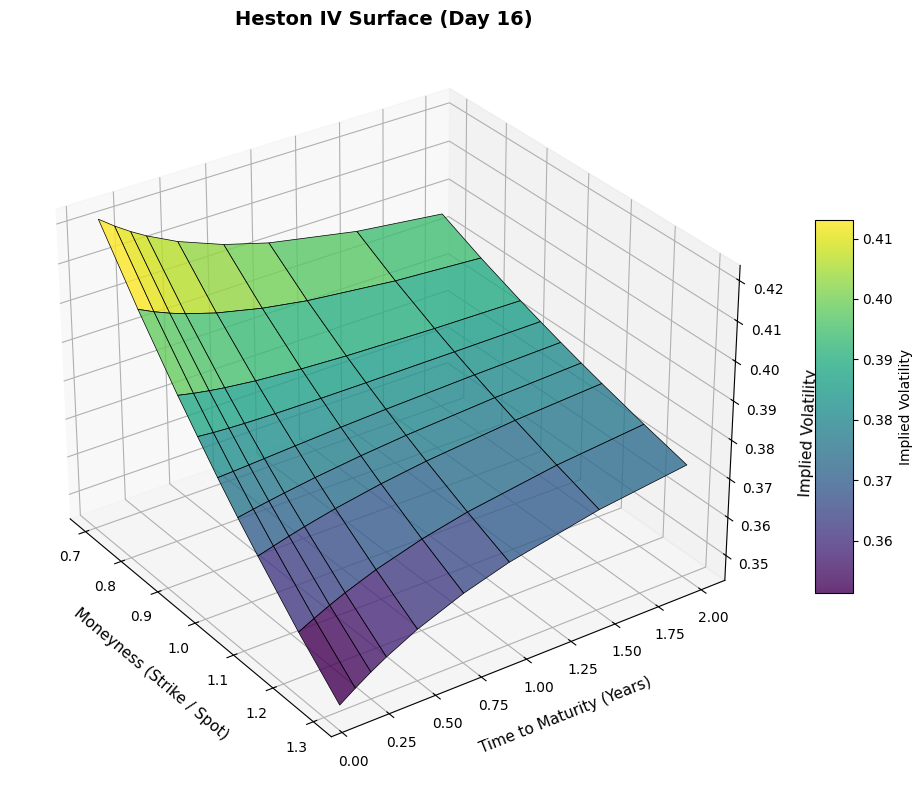

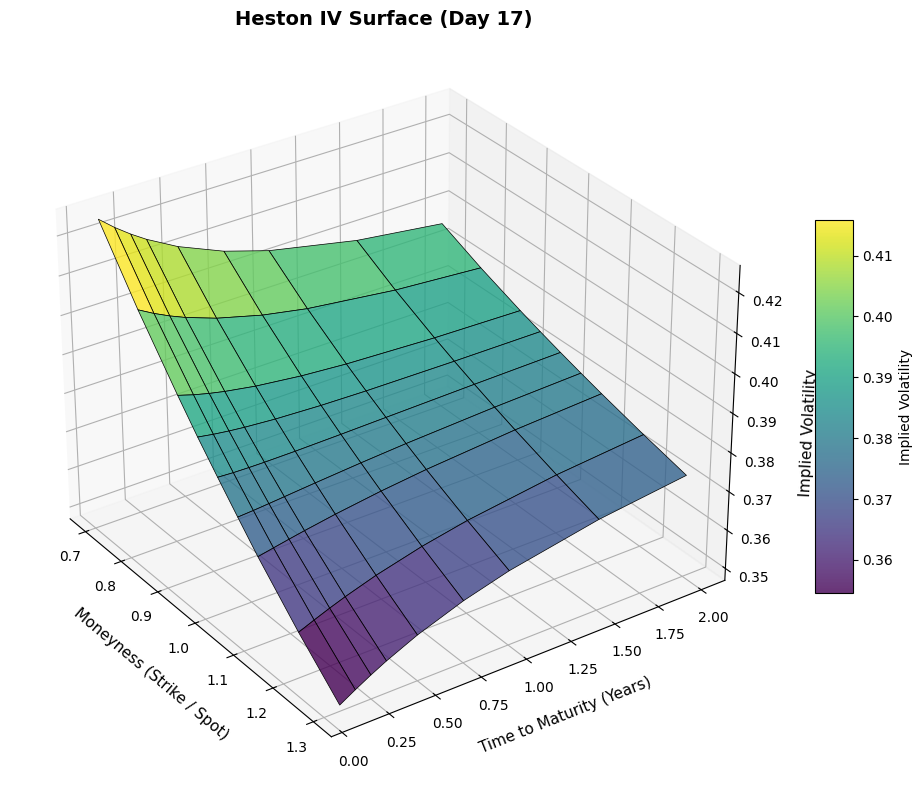

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq

# ... [KEEP YOUR FFT FUNCTIONS: HestonParams, heston_cf, heston_fft_calls] ...

# --- Helper: Black-Scholes Solver for IV ---
def bs_call_price(S, K, T, r, sigma):
    if T <= 1e-5: return np.maximum(S - K, 0.0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_vol(price, S, K, T, r):
    intrinsic = np.maximum(S - K * np.exp(-r * T), 0)
    if price <= intrinsic + 1e-6: return np.nan
    def obj(sigma): return bs_call_price(S, K, T, r, sigma) - price
    try: return brentq(obj, 1e-5, 5.0)
    except: return np.nan

# ==========================================
# Main Execution Block
# ==========================================

# 1. Simulation Parameters
S0, r, q = 100.0, 0.05, 0.0
kappa, theta, sigma, rho = 3, 0.15, 0.3, -0.7 
# try rho to be -0.5
# sigma 0.6
# theta 0.04
# kappa to be 1

# kappa_vec = rng.uniform(1.0, 2.0, n_days_raw)
# theta_vec = rng.uniform(0.1, 0.5, n_days_raw)
# sigma_vec = rng.uniform(0.3, 0.9, n_days_raw)
# rho_vec   = rng.uniform(-0.9, -0.1, n_days_raw)
v0 = 0.2
# try v0 to be 0.04

# 2. Define the Surface Grid
moneyness_grid = np.array([0.7, 0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2, 1.3])
ttm_grid = np.array([1/12, 1/6, 1/4, 1/3, 1/2, 3/4, 1.0, 1.5, 2])
mu = 0.05

# 3. Simulate Path (Day 0 to Day 100)
n_days_raw = 10000
dt = 1/252.0
S_path = np.zeros(n_days_raw); S_path[0] = S0
v_path = np.zeros(n_days_raw); v_path[0] = v0

rng = np.random.default_rng(42)
for t in range(n_days_raw - 1):
    Z1, Z2 = rng.normal(), rng.normal()
    W_S = Z1
    W_v = rho*Z1 + np.sqrt(1-rho**2)*Z2
    
    v_pos = max(v_path[t], 0)
    dv = kappa*(theta - v_pos)*dt + sigma*np.sqrt(v_pos*dt)*W_v
    v_path[t+1] = v_pos + dv
    S_path[t+1] = S_path[t] * np.exp((mu + r - 0.5*v_pos)*dt + np.sqrt(v_pos*dt)*W_S) # mu is added here

# 4. Generate Surface Tensor (Raw: includes Day 0)
iv_tensor_raw = np.zeros((n_days_raw, len(moneyness_grid), len(ttm_grid)))

print(f"Generating Surfaces for {n_days_raw} days...")

for day in range(n_days_raw):
    curr_S = S_path[day]
    curr_v = max(v_path[day], 1e-6)
    day_params = HestonParams(kappa, theta, sigma, rho, curr_v)
    
    for t_idx, T_exp in enumerate(ttm_grid):
        K_fft, C_fft = heston_fft_calls(curr_S, T_exp, r, q, day_params, N=4096, eta=0.25)
        target_strikes = curr_S * moneyness_grid
        interp_prices = np.interp(target_strikes, K_fft, C_fft)
        
        for m_idx, (K_target, price) in enumerate(zip(target_strikes, interp_prices)):
            iv = implied_vol(price, curr_S, K_target, T_exp, r)
            iv_tensor_raw[day, m_idx, t_idx] = iv

# 5. Generate Features (Raw: includes Day 0)
print("Generating Features...")
s_series = pd.Series(S_path)
v_series = pd.Series(v_path)

# Calculate Daily Returns (Day 0 will be 0.0)
ret_price = np.log(s_series / s_series.shift(1)).fillna(0)
ret_sq = ret_price ** 2
ret_vol = np.log(np.sqrt(v_series) / np.sqrt(v_series).shift(1)).fillna(0)

# Calculate EWMAs
short_span, long_span = 5, 20
ewma_ret_s = ret_price.ewm(span=short_span, adjust=False).mean()
ewma_ret_l = ret_price.ewm(span=long_span, adjust=False).mean()
ewma_sq_s  = ret_sq.ewm(span=short_span, adjust=False).mean()
ewma_sq_l  = ret_sq.ewm(span=long_span, adjust=False).mean()

features_raw = np.column_stack([
    ewma_ret_s.values, ewma_ret_l.values,
    ewma_sq_s.values, ewma_sq_l.values,
    ret_vol.values
])

# 6. TRIM DATASETS (Remove Day 0)
# We throw away index 0 because it has no history/returns
iv_tensor = iv_tensor_raw[1:]
features  = features_raw[1:]
S_path    = S_path[1:]
v_path    = v_path[1:]

print("-" * 30)
print(f"Original Days: {n_days_raw}")
print(f"Final Tensor Shape:   {iv_tensor.shape}") # Should be (99, 9, 9)
print(f"Final Features Shape: {features.shape}")  # Should be (99, 5)
print("-" * 30)


plot_iv_surface(iv_tensor, 16, moneyness_grid, ttm_grid)
plot_iv_surface(iv_tensor, 17, moneyness_grid, ttm_grid)

In [3]:
np.isnan(iv_tensor).sum()

np.int64(0)

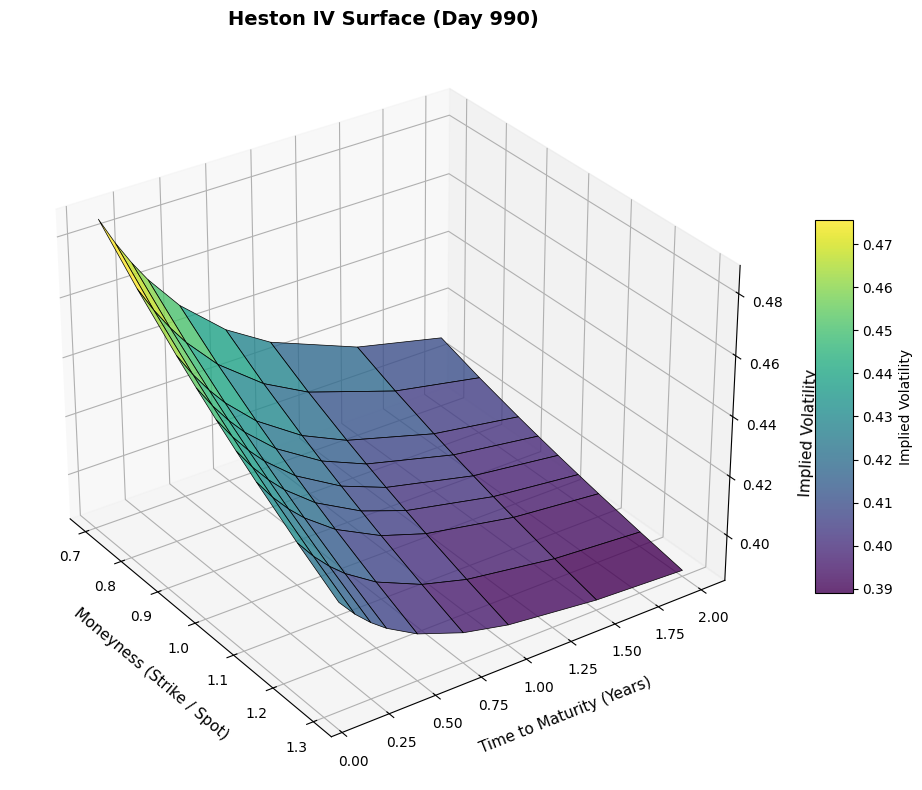

In [4]:
plot_iv_surface(iv_tensor, 990, moneyness_grid, ttm_grid)

Generating Penalty Matrices...
Calculating Penalties for Heston Surfaces...
Calculation Complete.
Average Daily Penalty: 0.00000000


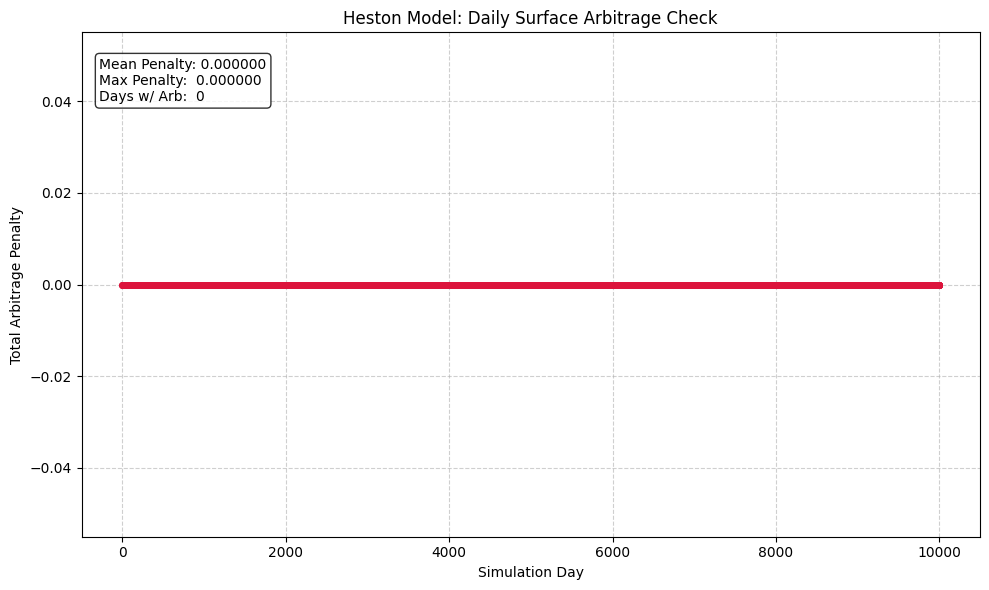

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

# ==========================================
# 1. User's Arbitrage Helper Functions
# ==========================================

def smallBS(m, tau, sigma, r):
    # vectorized BS call pricer
    d1 = (-np.log(m) + tau*(r + 0.5*sigma*sigma)) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    price = norm.cdf(d1) - m*norm.cdf(d2)*np.exp(-r*tau)
    return price

def penalty_mutau(mu, T):
    P_T = np.zeros((len(T), len(T)))
    P_K = np.zeros((len(mu), len(mu)))
    PB_K = np.zeros((len(mu), len(mu)))
    
    # Calendar Spread (Time) Matrix
    for j in np.arange(0, len(T)-1, 1):
        P_T[j, j] = T[j] / (T[j+1] - T[j])
        P_T[j+1, j] = -T[j] / (T[j+1] - T[j])
        
    # Vertical Spread (Strike) Matrix
    for i in np.arange(0, len(mu)-1, 1):
        P_K[i, i] = -1 / (mu[i+1] - mu[i])
        P_K[i, i+1] = 1 / (mu[i+1] - mu[i])
        
    # Butterfly Spread (Convexity) Matrix
    for i in np.arange(1, len(mu)-1, 1):
        PB_K[i, i-1] = -(mu[i+1] - mu[i]) / ((mu[i] - mu[i-1]) * (mu[i+1] - mu[i]))
        PB_K[i, i] = (mu[i+1] - mu[i-1]) / ((mu[i] - mu[i-1]) * (mu[i+1] - mu[i]))
        PB_K[i, i+1] = -(mu[i] - mu[i-1]) / ((mu[i] - mu[i-1]) * (mu[i+1] - mu[i]))
        
    return P_T, P_K, PB_K

def calculate_penalties_vectorized(iv_tensor, m_grid, ttm_grid, P_T, P_K, PB_K, r_val=0.0):
    # Ensure shape is (N, Moneyness, TTM)
    if iv_tensor.ndim == 4:
        iv_tensor = np.squeeze(iv_tensor, axis=1)

    M, T = np.meshgrid(m_grid, ttm_grid, indexing='ij')
    M = M[np.newaxis, :, :]
    T = T[np.newaxis, :, :]
    
    # Calculate Prices from IVs
    price_tensor = smallBS(M, T, iv_tensor, r_val)

    # 1. Calendar Arbitrage (P1)
    # Checks if Price decreases with Time (Violation)
    P1 = np.maximum(0, price_tensor @ P_T)
    
    # 2. Vertical Spread Arbitrage (P2)
    # Checks if Price increases with Strike (Violation for Calls)
    P2 = np.maximum(0, np.einsum('ij,njk->nik', P_K, price_tensor))
    
    # 3. Butterfly Arbitrage (P3)
    # Checks for negative convexity (Violation)
    P3 = np.maximum(0, np.einsum('ij,njk->nik', PB_K, price_tensor))

    # Sum penalties per surface
    total_penalty_per_surface = np.sum(P1 + P2 + P3, axis=(1, 2))

    return P1, P2, P3, total_penalty_per_surface

def plot_heston_arbitrage(penalties):
    """
    Plots the arbitrage penalty evolution over the simulated days.
    """
    days = np.arange(len(penalties))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(days, penalties, color='crimson', marker='o', linestyle='-', linewidth=1.5, markersize=4)
    
    ax.set_xlabel('Simulation Day')
    ax.set_ylabel('Total Arbitrage Penalty')
    ax.set_title('Heston Model: Daily Surface Arbitrage Check')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add statistics to the plot
    stats_text = (f"Mean Penalty: {np.mean(penalties):.6f}\n"
                  f"Max Penalty:  {np.max(penalties):.6f}\n"
                  f"Days w/ Arb:  {np.sum(penalties > 1e-6)}")
    
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. Execute on Heston Data
# ==========================================

# NOTE: Ensure 'iv_tensor_final', 'moneyness_grid', and 'ttm_grid' 
# are available from the previous simulation step.

print("Generating Penalty Matrices...")
# Calculate the finite difference matrices once
P_T, P_K, PB_K = penalty_mutau(moneyness_grid, ttm_grid)

print("Calculating Penalties for Heston Surfaces...")
# iv_tensor_final shape is (99, 9, 9)
p1, p2, p3, total_penalties = calculate_penalties_vectorized(
    iv_tensor, 
    moneyness_grid, 
    ttm_grid, 
    P_T, P_K, PB_K, 
    r_val=0.0 # Use the 'r' from your simulation
)

print(f"Calculation Complete.")
print(f"Average Daily Penalty: {np.mean(total_penalties):.8f}")

# Plot
plot_heston_arbitrage(total_penalties)

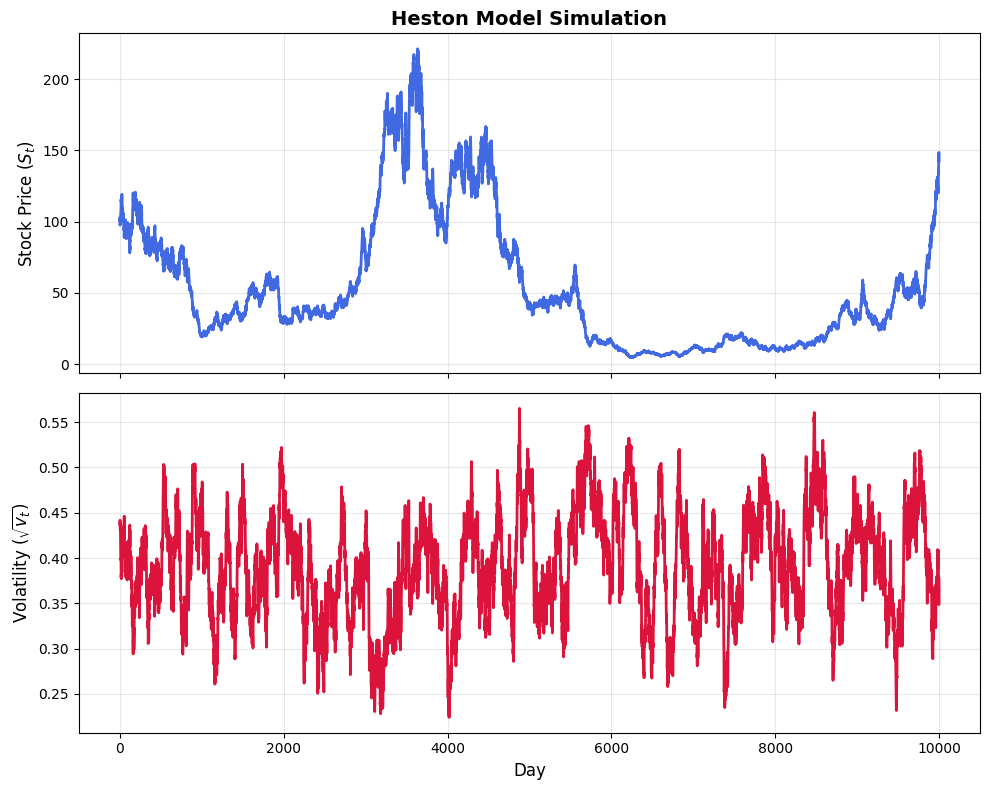

In [26]:
import matplotlib.pyplot as plt

def plot_simulation_paths(S_path, v_path):
    """
    Plots the Stock Price and Volatility paths side-by-side.
    """
    days = np.arange(len(S_path))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # 1. Stock Price Plot
    ax1.plot(days, S_path, color='royalblue', lw=2)
    ax1.set_ylabel('Stock Price ($S_t$)', fontsize=12)
    ax1.set_title('Heston Model Simulation', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. Volatility Plot (Square root of variance)
    vol_path = np.sqrt(v_path)
    ax2.plot(days, vol_path, color='crimson', lw=2)
    ax2.set_ylabel('Volatility ($\sqrt{v_t}$)', fontsize=12)
    ax2.set_xlabel('Day', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- Run this after your simulation ---
plot_simulation_paths(S_path, v_path)

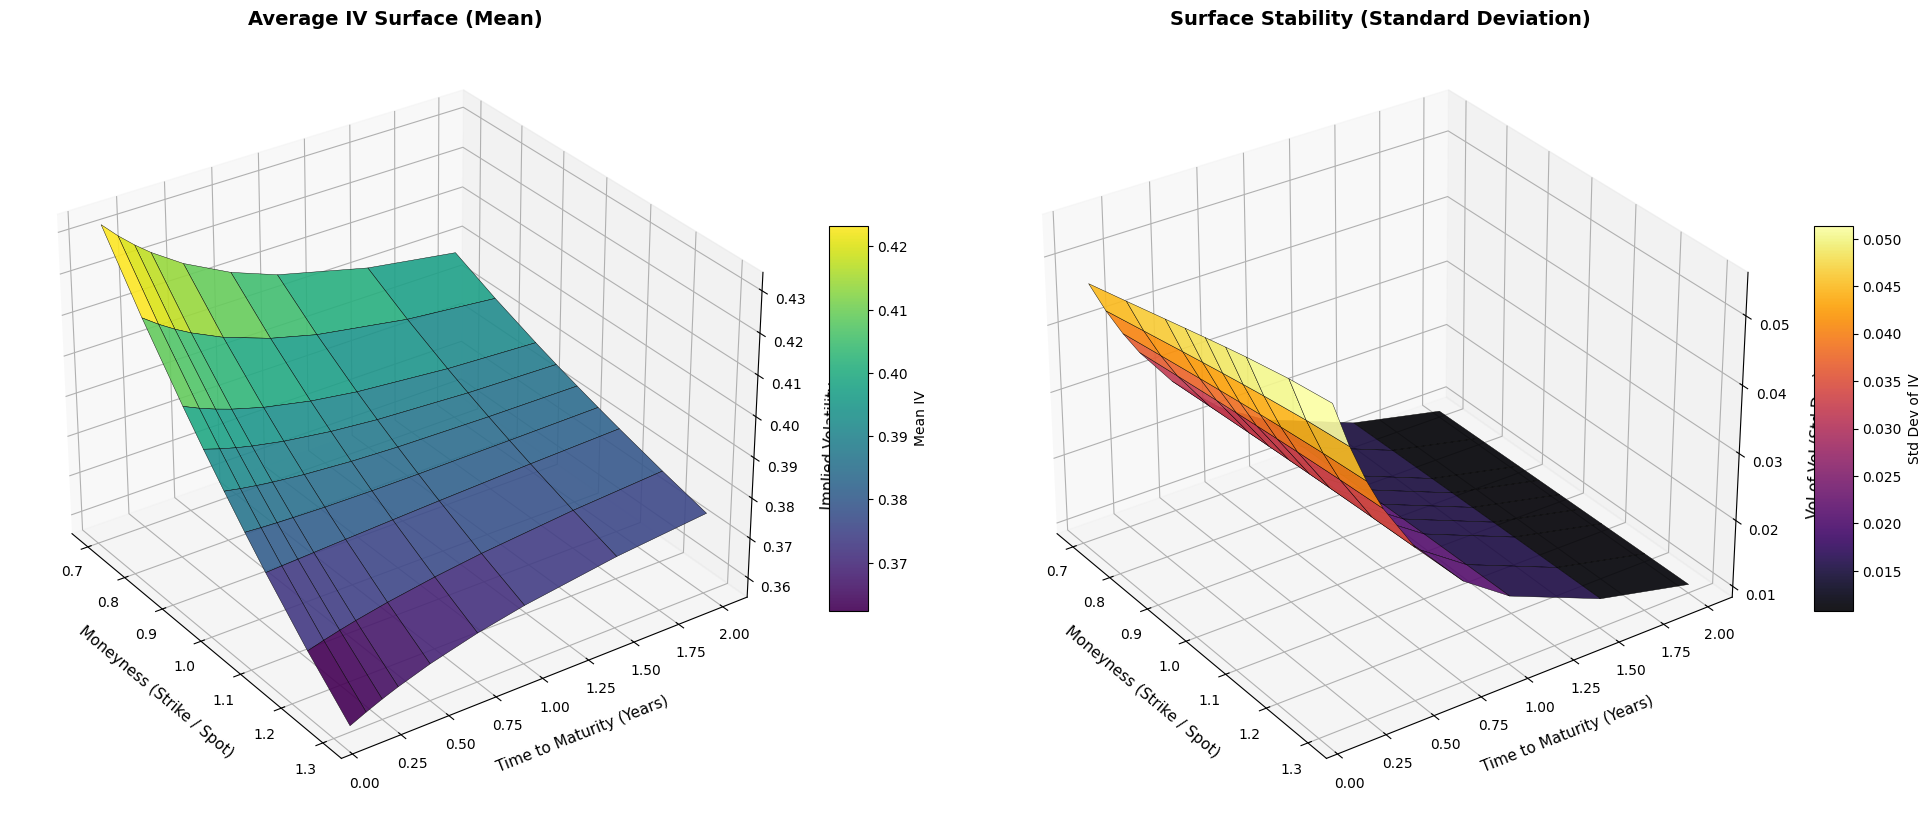

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_aggregated_surfaces(iv_tensor, moneyness_grid, ttm_grid):
    """
    Calculates and plots the Mean and Standard Deviation of the IV surfaces
    across the time dimension (n_days), using the specified view angle (30, -35).
    
    Parameters:
    - iv_tensor: 3D array of shape (n_days, n_moneyness, n_ttm)
    - moneyness_grid: 1D array of moneyness values
    - ttm_grid: 1D array of time-to-maturity values
    """
    # 1. Calculate Statistics (Aggregate over axis 0 = days)
    mean_surface = np.nanmean(iv_tensor, axis=0)
    std_surface = np.nanstd(iv_tensor, axis=0)
    
    # 2. Create Grid for Plotting
    M, T = np.meshgrid(moneyness_grid, ttm_grid, indexing='ij')
    
    # 3. Setup Figure
    fig = plt.figure(figsize=(20, 8))
    
    # --- Subplot 1: Mean Surface ---
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(M, T, mean_surface, cmap=cm.viridis, 
                             edgecolor='k', linewidth=0.3, alpha=0.9)
    
    ax1.set_title("Average IV Surface (Mean)", fontsize=14, fontweight='bold')
    ax1.set_xlabel('Moneyness (Strike / Spot)', fontsize=11, labelpad=10)
    ax1.set_ylabel('Time to Maturity (Years)', fontsize=11, labelpad=10)
    ax1.set_zlabel('Implied Volatility', fontsize=11, labelpad=10)
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10, label='Mean IV')
    
    # Set requested view angle
    ax1.view_init(elev=30, azim=-35)

    # --- Subplot 2: Std Deviation Surface ---
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(M, T, std_surface, cmap=cm.inferno, 
                             edgecolor='k', linewidth=0.3, alpha=0.9)
    
    ax2.set_title("Surface Stability (Standard Deviation)", fontsize=14, fontweight='bold')
    ax2.set_xlabel('Moneyness (Strike / Spot)', fontsize=11, labelpad=10)
    ax2.set_ylabel('Time to Maturity (Years)', fontsize=11, labelpad=10)
    ax2.set_zlabel('Vol of Vol (Std Dev)', fontsize=11, labelpad=10)
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10, label='Std Dev of IV')
    
    # Set requested view angle
    ax2.view_init(elev=30, azim=-35)

    plt.tight_layout()
    plt.show()

# --- Example Usage ---
plot_aggregated_surfaces(iv_tensor, moneyness_grid, ttm_grid)

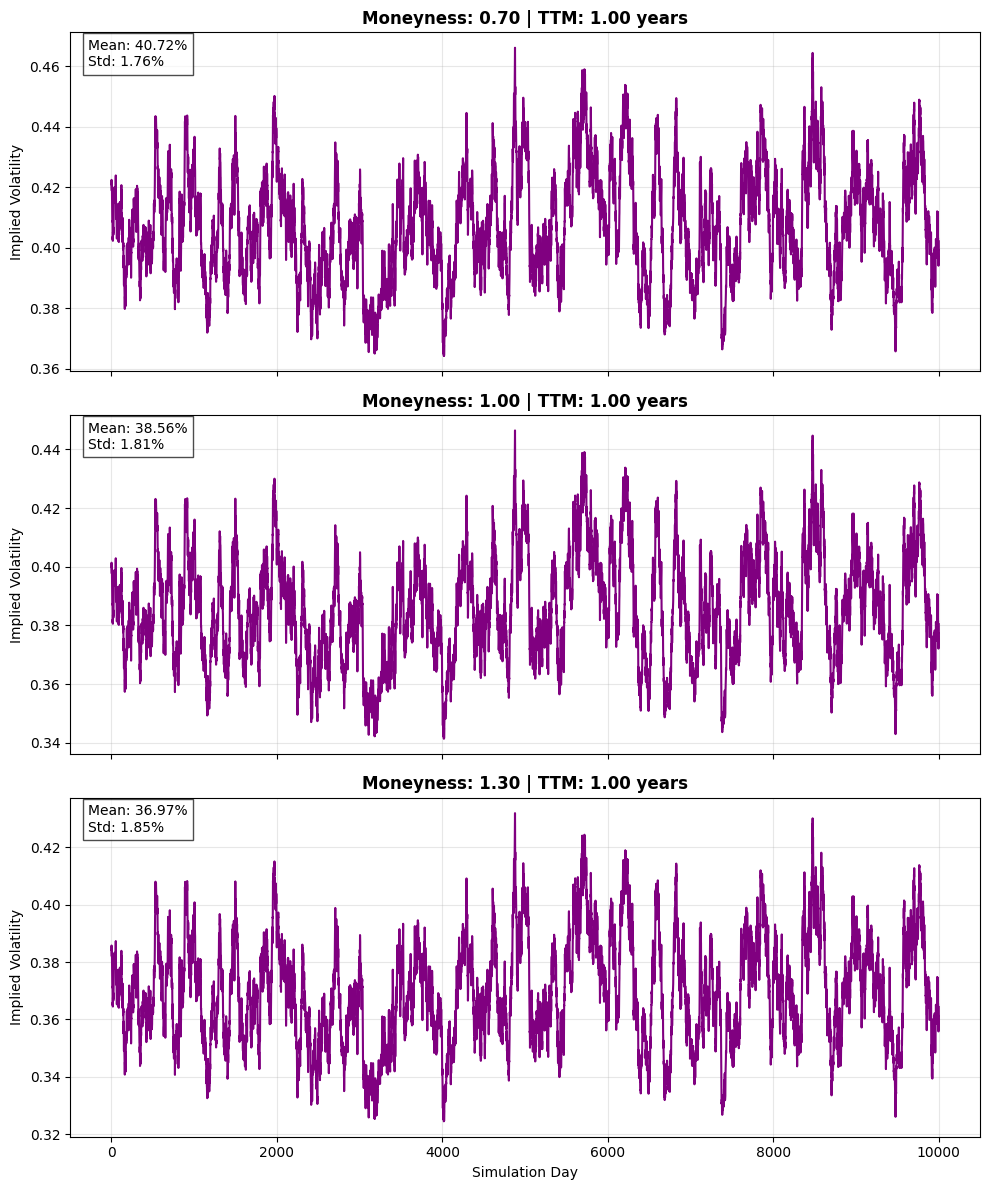

In [27]:
def plot_selected_iv_timeseries(iv_tensor, moneyness_grid, ttm_grid, selected_moneyness, selected_ttm):
    """
    Plots time series of IV for selected moneyness levels at a fixed TTM.
    """
    # Find the index for the selected TTM
    # We find the closest match in the grid
    ttm_idx = (np.abs(ttm_grid - selected_ttm)).argmin()
    actual_ttm = ttm_grid[ttm_idx]
    
    fig, axes = plt.subplots(len(selected_moneyness), 1, figsize=(10, 12), sharex=True)
    
    days = np.arange(iv_tensor.shape[0])
    
    for i, target_m in enumerate(selected_moneyness):
        # Find closest moneyness index
        m_idx = (np.abs(moneyness_grid - target_m)).argmin()
        actual_m = moneyness_grid[m_idx]
        
        # Extract time series
        iv_series = iv_tensor[:, m_idx, ttm_idx]
        
        ax = axes[i]
        ax.plot(days, iv_series, color='purple', linewidth=1.5)
        ax.set_title(f"Moneyness: {actual_m:.2f} | TTM: {actual_ttm:.2f} years", fontsize=12, fontweight='bold')
        ax.set_ylabel("Implied Volatility")
        ax.grid(True, alpha=0.3)
        
        # Add basic stats
        mean_iv = np.mean(iv_series)
        std_iv = np.std(iv_series)
        ax.text(0.02, 0.9, f"Mean: {mean_iv:.2%}\nStd: {std_iv:.2%}", 
                transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.7))

    axes[-1].set_xlabel("Simulation Day")
    plt.tight_layout()
    plt.show()

# --- Configuration ---
# Pick 3 representative moneyness levels (e.g., Deep ITM, ATM, Deep OTM)
selected_m = [0.7, 1.0, 1.3]
# Pick 1 representative maturity (e.g., 1 year)
selected_t = 1.0

# Execute
plot_selected_iv_timeseries(iv_tensor, moneyness_grid, ttm_grid, selected_m, selected_t)

In [31]:
# generate the synthetic date array for the features
n_needed = len(features) 
dates_obj = pd.date_range(start='2024-01-01', periods=n_needed, freq='B')
date_array = dates_obj.strftime('%Y-%m-%d').to_numpy()
print(f"Data Length: {n_needed}")
print(f"Date Length: {len(date_array)}")
print(f"First Date:  {date_array[0]}")
print(f"Last Date:   {date_array[-1]}")

Data Length: 9999
Date Length: 9999
First Date:  2024-01-01
Last Date:   2062-04-27


In [33]:
np.save("heston_iv_tensor.npy", iv_tensor, allow_pickle=False)
np.save("heston_features.npy", features, allow_pickle=False)
np.save("heston_dates.npy", date_array)

In [30]:
nan_count = np.isnan(iv_tensor).sum()
nan_count

np.int64(0)

Below is the flattened version formatted for VolGAN codes

In [7]:
# ==========================================
# 7. Data Formatting & Saving (Aligned)
# ==========================================

# A. Create Date Index (Business Days starting 2030-01-01)
# We generated 10,000 rows (after trimming).
# We want the FIRST row of the file to be Jan 1, 2030.
dates_final = pd.bdate_range(start='2030-01-01', periods=len(S_path))

# B. Prepare Market Data DataFrame
# We need the Raw S_path (before trimming) to get the correct prev_close for the first row.
# Assuming 's_series' is the pd.Series of the FULL (10001) path from step 5:
# s_series[0] = Day 0 (100.0)
# s_series[1] = Day 1
# ...
# We want the file to contain Day 1 to Day 10000.

df_market = pd.DataFrame({
    'date': dates_final,
    'close': S_path,  # This is already trimmed (Day 1 to 10000)
    # prev_close must be aligned: item 0 should be Day 0 (100), item 1 should be Day 1...
    # We take the first 10000 elements of the RAW series (Day 0 to Day 9999)
    'prev_close': s_series.values[:-1], 
    'log_return': features[:, 0] # Or recalculate: np.log(S_path / s_series.values[:-1])
})

# Recalculate log_return explicitly to be safe and ensure alignment
df_market['log_return'] = np.log(df_market['close'] / df_market['prev_close'])

# C. Prepare IV Surface DataFrame
# Reshape to (10000, 81)
iv_flattened = iv_tensor.reshape(len(iv_tensor), -1)
df_iv = pd.DataFrame(iv_flattened, index=dates_final) 

# Check alignment
print(f"IV Start Date:     {df_iv.index[0]}")
print(f"Market Start Date: {df_market['date'].iloc[0]}")
print(f"Market Prev Close Day 1: {df_market['prev_close'].iloc[0]}") # Should be 100.0

# ==========================================
# 8. Save to CSV
# ==========================================

# Save File 1: IV Surface
# Requirements: Date as index, No Header
df_iv.to_csv('iv_surface.csv', header=False, index=True)
print("Saved: iv_surface.csv")

# Save File 2: Market Data
# Requirements: Date as standalone column, No index column
df_market.to_csv('market_data.csv', index=False)
print("Saved: market_data.csv")

IV Start Date:     2030-01-01 00:00:00
Market Start Date: 2030-01-01 00:00:00
Market Prev Close Day 1: 100.0
Saved: iv_surface.csv
Saved: market_data.csv
